# 将CNN各层可视化
---
在这个notebook中，我们要加载一个已训练的CNN（从解决方案到FashionMNIST），并实现几种特征可视化技术，从而了解该网络已经学会了提取哪些特征。

### 加载 [数据](http://pytorch.org/docs/stable/torchvision/datasets.html) 

在这个单元格中，我们只加载FashionMNIST类中的**测试**数据集。

In [1]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the test data
print('Test data, number of images: ', len(test_data))

Test data, number of images:  10000


In [2]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 将一些测试数据可视化

该单元格会遍历该训练数据集，并使用`dataiter.next()`加载一个随机批次的图像/标签数据。然后，它会在`2 x batch_size/2`网格中将这批图像和标签可视化。

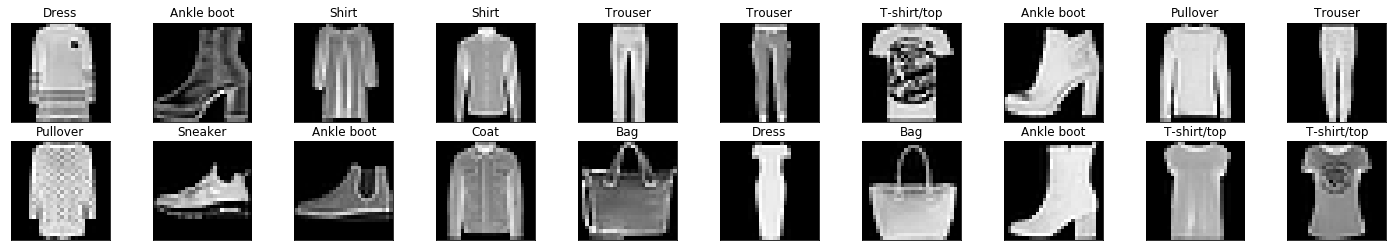

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])



### 定义网络架构

 [这里](http://pytorch.org/docs/stable/nn.html)记录了构成任何一种神经网络所需的各个层。对于卷积神经网络，我们将使用下列几个简单的层：
* 卷积层
* 最大池化层
* 全连接层（线性层）

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x


### 加载已训练的网络

这个notebook需要知道之前定义的网络架构，知道“Net”类的外观后，我们就可以实例化一个模型并在已训练的网络中进行加载。

上面的网络架构取自示例解决方案代码，该代码已经过训练并保存在目录`saved_models/`中。

In [5]:
# instantiate your Net
net = Net()

# load the net parameters by name
net.load_state_dict(torch.load('saved_models/fashion_net_ex.pt'))

print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## 特征可视化

有时，神经网络会被当做是一个黑盒子，给定一些输入，它就会学习产生一些输出。 事实上，CNN正在学习识别各种空间模式，你可以通过查看构成每个卷积核的权重并将这些权重一次性应用于样本图像来可视化每个卷积层已被训练识别的内容。这种技术称为特征可视化，它对于理解CNN的内部工作方式来说很有帮助。

在下面的单元格中，你将要看到如何提取和可视化第一个卷积层中所有滤波器的滤波权重。

请注意亮像素和暗像素的模式，看看是否可以判断特定滤波检测到的是什么。例如，下面示例中所示的滤波在任一侧都有暗像素，在中间列中有亮像素，因此可能会检测到垂直边缘。

<img src='edge_filter_ex.png' width= 30% height=30%/>

First convolutional layer


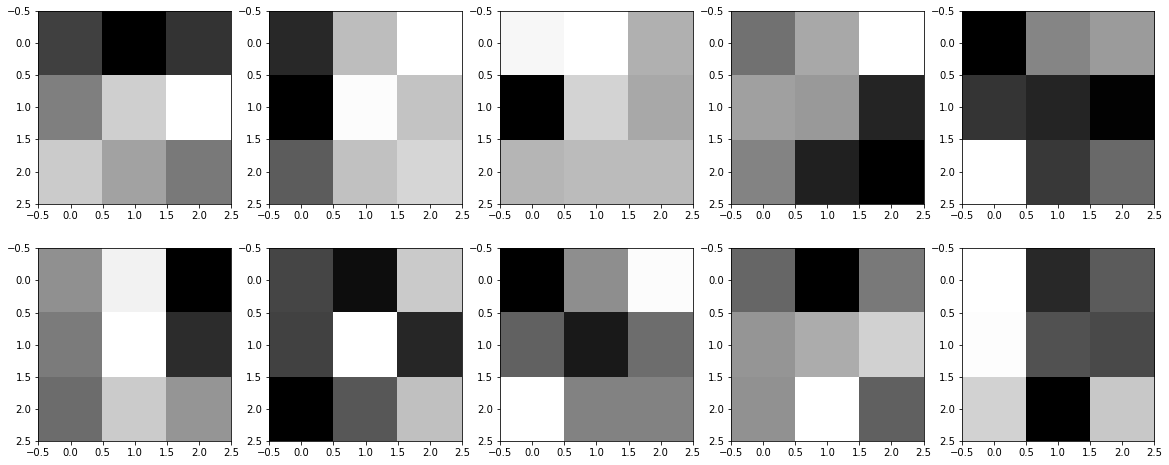

In [6]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()



### 激活映射图

接下来，你将要看到的是如何使用OpenCV的`filter2D`函数将这些滤波器应用于示例测试图像，并生成一系列**激活映射图**。我们将对第一个和第二个卷积层执行此操作，这些激活映射图可以让你真正了解每个滤波器学习提取的特征有哪些。

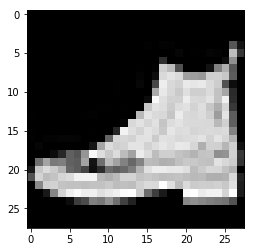

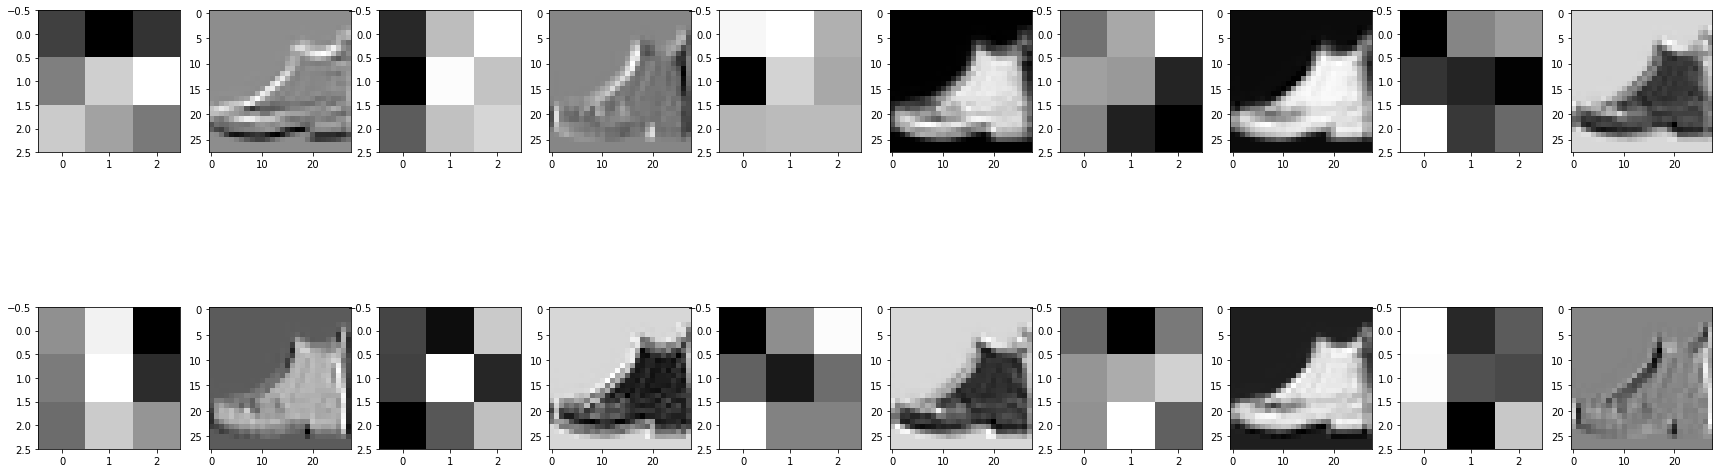

In [7]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

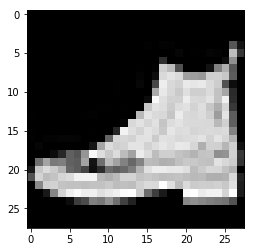

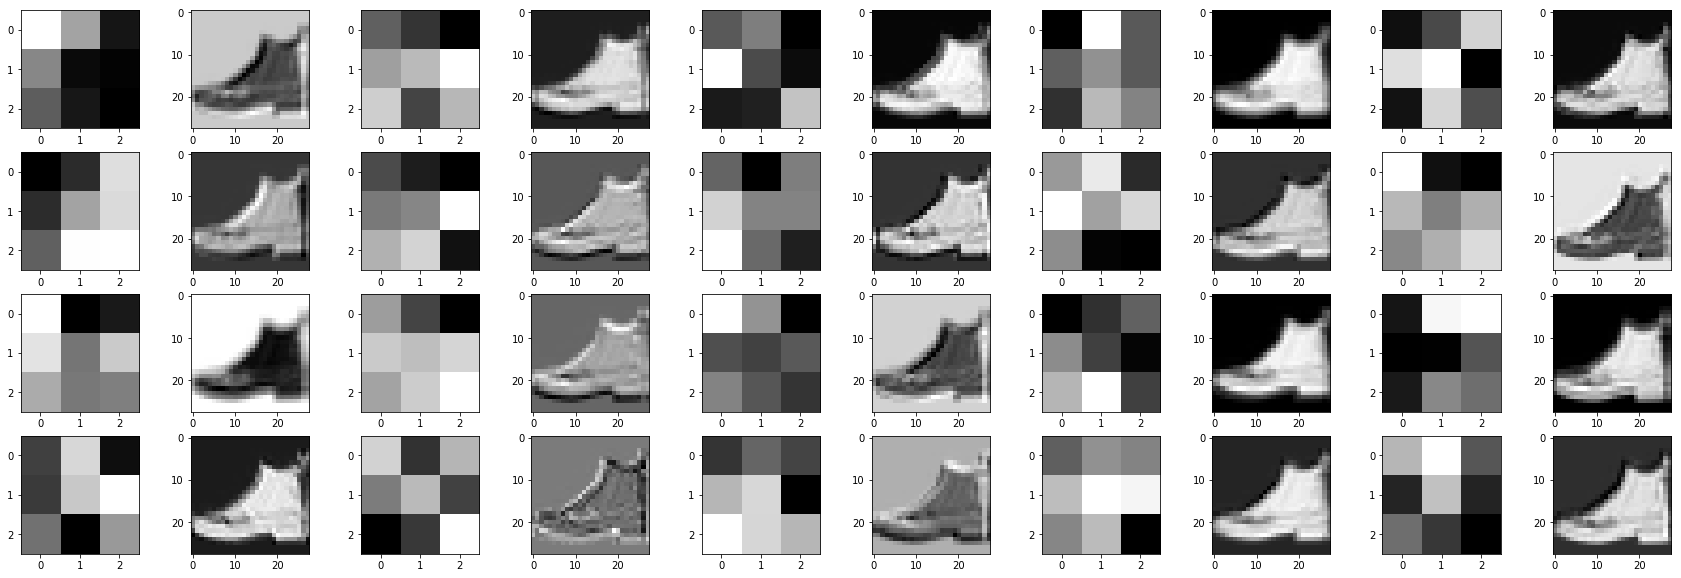

In [8]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()



### 问题：从已训练的卷积层中选择一个滤波器，然后看一看这些激活映射图，你认为这个滤波器会起到什么作用？你认为它会检测到哪种特征？


**答案**: 在第一个卷积层（conv1）中，第一个滤波器（如左上角网格角中所示）似乎检测到了水平边缘。它有一个负加权的顶行和正加权的中间行和最底部的行，似乎可以检测到套衫中袖子的水平边缘。

在第二个卷积层（conv2）中，第一个滤波器看起来可能检测到了背景颜色（因为这是滤波图像中最亮的区域）和套头衫的垂直边缘。